In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
import pickle
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from skimage import measure, segmentation, feature
from vis_utils import load_volume, VolumeVisualizer, ColorMapVisualizer
from skimage.morphology import skeletonize, skeletonize_3d, binary_dilation, convex_hull_image
from skimage import filters, morphology
from scipy.ndimage import zoom
from scipy.ndimage.filters import convolve, correlate
from scipy import signal
from skimage.filters import frangi, sato
from skimage.draw import line_nd
from PIL import Image
from queue import PriorityQueue

In [2]:
TREE_NAME = 'P12'

## Loading DAG and thiccness map

In [3]:
class Node:
    def __init__(self, coords):
        self.coords = coords
        self.edges = []
        self.data = {}
            
    def add_edge(self, edge):
        self.edges.append(edge)
        
    def get_neighbours(self):
        return [e.node_a if e.node_a.coords != self.coords else e.node_b for e in self.edges]
    
    def copy_without_edges(self):
        copied_node = Node(self.coords)
        copied_node.data = self.data
        return copied_node
    
    def __setitem__(self, key, value):
        self.data[key] = value
    
    def __getitem__(self, key):
        return self.data[key]
    
    def __hash__(self):
        return hash(self.coords)
    
    def __repr__(self):
        return f'Node {str(self.coords)}'
       
        
class Edge:
    def __init__(self, node_a, node_b):
        self.node_a = node_a
        self.node_b = node_b
        self.data = {}
        
    def __setitem__(self, key, value):
        self.data[key] = value
    
    def __getitem__(self, key):
        return self.data[key]
    
    def __repr__(self):
        return f'Edge {self.node_a.coords} -> {self.node_b.coords}'

    
class DAG:
    def __init__(self, root, volume_shape):
        self.root = root
        self.nodes = get_nodes_with_dfs(root)
        self.edges = get_edges_with_dfs(root)
        self.volume_shape = volume_shape
        self.data = {}
    
    def __setitem__(self, key, value):
        self.data[key] = value
    
    def __getitem__(self, key):
        return self.data[key]
           

def save_dag(dag, filename):
    with open(filename, 'wb') as output:
        pickle.dump(dag, output)
        

def load_dag(filename):
    with open(filename, 'rb') as input_:
        dag = pickle.load(input_)
        return dag

In [4]:
source_dir = './data/'
dag = load_dag(source_dir + TREE_NAME + '/dag.pkl')
reconstruction = np.load(source_dir + TREE_NAME + '/reconstruction.npy')

## Utility visualisation functions

In [5]:
def visualize_addition(base, base_with_addition):
    base = (base.copy() > 0).astype(np.uint8)
    addition = (base_with_addition > 0).astype(np.uint8)
    addition[base == 1] = 0
    ColorMapVisualizer(base + addition * 4).visualize()
    
def visualize_lsd(lsd_mask):
    ColorMapVisualizer(lsd_mask.astype(np.uint8)).visualize()
    
def visualize_gradient(lsd_mask):
    ColorMapVisualizer(lsd_mask.astype(np.uint8)).visualize(gradient=True)
    
def visualize_mask_bin(mask):
    VolumeVisualizer((mask > 0).astype(np.uint8), binary=True).visualize()
    
def visualize_mask_non_bin(mask):
    VolumeVisualizer((mask > 0).astype(np.uint8) * 255, binary=False).visualize()
    
def visualize_skeleton(mask, visualize_mask=True, visualize_both_versions=False):
    skeleton = skeletonize((mask > 0).astype(np.uint8))
    if not visualize_mask or visualize_both_versions:
        VolumeVisualizer(skeleton, binary=True).visualize()
    if visualize_mask or visualize_both_versions:
        skeleton = skeleton.astype(np.uint8) * 4
        mask = (mask > 0).astype(np.uint8) * 3
        mask[skeleton != 0] = 0
        ColorMapVisualizer(skeleton + mask).visualize()

def visualize_ultimate(lsd, base_mask):
    visualize_lsd(lsd)
    visualize_mask_non_bin(lsd)
    visualize_addition(base_mask, lsd)
    visualize_skeleton(lsd, visualize_mask=True)

## DAG visualization

In [6]:
def spherical_kernel(outer_radius, thickness=1, filled=True):    
    outer_sphere = morphology.ball(radius=outer_radius)
    if filled:
        return outer_sphere
    
    thickness = min(thickness, outer_radius)
    
    inner_radius = outer_radius - thickness
    inner_sphere = morphology.ball(radius=inner_radius)
    
    begin = outer_radius - inner_radius
    end = begin + inner_sphere.shape[0]
    outer_sphere[begin:end, begin:end, begin:end] -= inner_sphere
    return outer_sphere


def print_kernels(image, nodes, value):
    image = image.copy()
    max_kernel_radius = int(max([node['thiccness'] for node in nodes]))
    kernels = [spherical_kernel(radius) for radius in range(max_kernel_radius + 1)]
    
    padded_image = np.pad(image, max_kernel_radius)
    kernels_image = np.zeros(padded_image.shape)
    
    for node in nodes:
        x, y, z = (coord + max_kernel_radius for coord in node.coords)
        kernel_radius = int(node['thiccness'])
        kernel = kernels[kernel_radius]
        
        mask_slice = kernels_image[
            x-kernel_radius:x+kernel_radius + 1,
            y-kernel_radius:y+kernel_radius + 1,
            z-kernel_radius:z+kernel_radius + 1
        ]
        
        mask_slice[:] = np.logical_or(mask_slice, kernel)
            
    kernels_image = kernels_image[
        max_kernel_radius:-max_kernel_radius,
        max_kernel_radius:-max_kernel_radius,
        max_kernel_radius:-max_kernel_radius
    ]
    
    image[kernels_image == 1] = value
    return image


def draw_nodes(image, nodes, value=2):
    nodes_image = print_kernels(image, nodes, value)
    return nodes_image

    
def draw_edges(image, edges, value='mean_thiccness', interpolate=True):
    image = image.copy()

    for i, edge in enumerate(edges):
        if type(value) == str:
            fill_value = edge[value]
        else:
            fill_value = value
        
        if interpolate:
            image[line_nd(edge.node_a.coords, edge.node_b.coords)] = fill_value
        else:
            for v in edge['voxels']:
                image[tuple(v)] = fill_value
    return image


def draw_central_line(image, dag):
    image_with_edges = draw_edges(image, dag.edges, value=1, interpolate=False)
    for n in dag.nodes:
        for v in n['voxels']:
            image_with_edges[tuple(v)] = 1
    return image_with_edges

In [7]:
visualization = np.zeros(dag.volume_shape)
visualization = draw_nodes(visualization, dag.nodes, 25)
visualization = draw_edges(visualization, dag.edges, value='mean_thiccness')
visualize_gradient(visualization)

## Bifurcations angles

In [8]:
def calculate_direction(source, points, weights):
    if len(weights) > len(points):
        weights = weights[:len(points)]
        
    points = points[:len(weights)]
    all_directions = points - source
    direction = np.average(all_directions, axis=0, weights=weights)
    return direction / np.linalg.norm(direction)
    

def calculate_edge_directions(edge, weights):
    start_point = edge.node_a['centroid']
    end_point = edge.node_b['centroid']
    start_direction = calculate_direction(start_point, edge['voxels'], weights)
    end_direction = calculate_direction(end_point, np.flip(edge['voxels'], axis=0), weights) * (-1)
    return start_direction, end_direction
    

def set_edges_directions(dag, weights=[1, 1, 1, 1, 0.6, 0.2]): 
    for edge in dag.edges:
        start_direction, end_direction = calculate_edge_directions(edge, weights)
        edge['start_direction'] = start_direction
        edge['end_direction'] = end_direction

In [9]:
%%time
direction_weights = {
    'P01': [1, 1, 1, 0.8, 0.6, 0.2],
    'P05': [1, 1, 1, 0.8, 0.6, 0.2],
    'P12': [1, 1, 0.6, 0.2],
}

set_edges_directions(dag, weights=direction_weights.get(TREE_NAME, [1, 1, 0.6, 0.2]))

CPU times: user 1.28 s, sys: 88.9 ms, total: 1.37 s
Wall time: 1.28 s


In [10]:
def draw_directions(image, edges, start_value=2, end_value=3, length=10):
    image = image.copy()

    for edge in edges:
        start_point = edge.node_a['centroid']
        end_point = start_point + length * edge['start_direction']
        end_point = np.maximum([0, 0, 0], end_point)
        end_point = np.minimum(np.array(image.shape) - 1, end_point)
        image[line_nd(start_point, end_point)] = start_value
        
        start_point = edge.node_b['centroid']
        end_point = start_point + length * edge['end_direction']
        end_point = np.maximum([0, 0, 0], end_point)
        end_point = np.minimum(np.array(image.shape) - 1, end_point)
        image[line_nd(start_point, end_point)] = end_value
        
    return image

In [11]:
img = np.zeros(dag.volume_shape)
img = draw_edges(img, dag.edges, value=2, interpolate=False)
img = draw_directions(img, dag.edges, start_value=1, end_value=3, length=15)
visualize_lsd(img)

In [12]:
def calculate_vectors_relative_angle(v1, v2):
    cosine = np.dot(v1,v2)
    return np.arccos(cosine)

def set_edges_relative_angles(node, parent_edge=None):
    for edge in node.edges:
        if parent_edge is not None:
            edge['relative_angle'] = calculate_vectors_relative_angle(
                parent_edge['end_direction'], edge['start_direction'])
        else:
            edge['relative_angle'] = None
                
        set_edges_relative_angles(edge.node_b, edge)

In [13]:
%%time
set_edges_relative_angles(dag.root)

CPU times: user 70.2 ms, sys: 31.2 ms, total: 101 ms
Wall time: 70.3 ms


/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arccos
  This is separate from the ipykernel package so we can avoid doing imports until


/home/jakub/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jakub/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


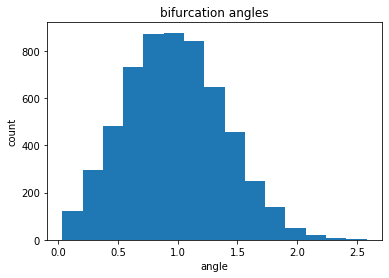

57.29577951308232

In [14]:
angles = [edge['relative_angle'] for edge in dag.edges[1:]]
plt.title('bifurcation angles')
plt.hist(angles, bins=15)

plt.xlabel('angle')
plt.ylabel('count')
plt.show()

(1 / np.pi) * 180

## Tortuosity (arc-chord ratio)

In [15]:
def set_edges_tortuosities(dag): 
    for edge in dag.edges:
        chord_length = np.linalg.norm(edge.node_b['centroid'] - edge.node_a['centroid'])
        edge['tortuosity'] = edge['length'] / chord_length

In [16]:
%%time
set_edges_tortuosities(dag)

CPU times: user 134 ms, sys: 31 ms, total: 165 ms
Wall time: 125 ms


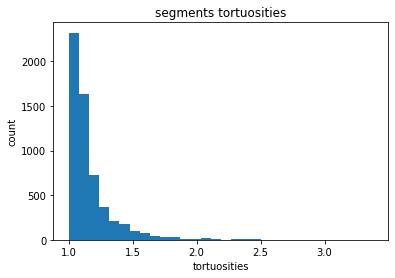

In [17]:
tortuosities = [edge['tortuosity'] for edge in dag.edges]
plt.title('segments tortuosities')
plt.hist(tortuosities, bins=30)

plt.xlabel('tortuosities')
plt.ylabel('count')
plt.show()

# Generations
## Finding main renal surface (2D projection)

In [18]:
central_line = np.zeros(dag.volume_shape)
central_line = draw_central_line(central_line, dag)
visualize_mask_bin(central_line)

In [19]:
def add_voxels_pca_mapping(dag, central_line_image):
    central_line_coords = np.argwhere(central_line_image > 0)
    pca = PCA(n_components=2)
    pca.fit(central_line_coords)
    
    for n in dag.nodes:
        n['voxels2d'] = pca.transform(n['voxels'])
    
    for e in dag.edges:
        e['voxels2d'] = pca.transform(e['voxels'])    

In [20]:
add_voxels_pca_mapping(dag, central_line)
print(dag.root['voxels'])
print(dag.root['voxels2d'])

[[531  77 333]]
[[-38.28248724 316.83586958]]


In [21]:
def add_symmetry_divergence_angles(dag):
    def calculate_vectors_relative_angle(v1, v2):
        v1 = v1 / np.linalg.norm(v1)
        v2 = v2 / np.linalg.norm(v2)
        cosine = np.dot(v1,v2)
        return np.arccos(cosine)
    
    root_2d_reference = np.mean(dag.root['voxels2d'], axis=0)
    symmetry_vector = np.zeros(2)
    symmetry_vector[1] = root_2d_reference[1] if root_2d_reference[1] < 0 else -root_2d_reference[1]
    
    for e in dag.edges:
        edge_centroid_2d = np.mean(e['voxels2d'], axis=0)
        edge_vector = edge_centroid_2d - root_2d_reference
        e['symmetry_divergence_angle'] = calculate_vectors_relative_angle(symmetry_vector, edge_vector)
        
    for n in dag.nodes:
        if n == dag.root:
            n['symmetry_divergence_angle'] = 0
            continue
    
        node_centroid_2d = np.mean(n['voxels2d'], axis=0)
        node_vector = node_centroid_2d - root_2d_reference
        n['symmetry_divergence_angle'] = calculate_vectors_relative_angle(symmetry_vector, node_vector)

In [22]:
add_symmetry_divergence_angles(dag)

In [23]:
visualization = np.zeros(dag.volume_shape)
visualization = draw_edges(visualization, dag.edges, interpolate=False, value='symmetry_divergence_angle')
visualize_gradient(np.ceil(visualization * 100 / np.pi))

## Calculating and scaling segment distances

In [24]:
def calculate_scaled_distance(dist, divergence_angle, x_scalar=1.0):
    return dist * np.cos(x_scalar * divergence_angle)


def recursive_add_root_path_distances(node, distance, x_scalar):
    node['distance_from_root'] = distance
    node['scaled_distance_from_root'] = calculate_scaled_distance(
        distance,
        node['symmetry_divergence_angle'],
        x_scalar
    )
    
    for e in node.edges:
        e['distance_from_root'] = node['distance_from_root']
        e['scaled_distance_from_root'] = node['scaled_distance_from_root']        
        new_distance = distance + e['length']
        recursive_add_root_path_distances(e.node_b, new_distance, x_scalar)
        
def add_root_path_distances(dag, x_scalar=1.0):
    recursive_add_root_path_distances(dag.root, 0., x_scalar)
    
    
def add_root_absolute_distances(dag, x_scalar=1.0):
    for n in dag.nodes:
        dist = np.linalg.norm(n['centroid'] - dag.root['centroid'])
        n['absolute_distance'] = dist
        n['scaled_absolute_distance'] = calculate_scaled_distance(
            dist,
            n['symmetry_divergence_angle'],
            x_scalar
        )
        
    for e in dag.edges:
        e['absolute_distance'] = e.node_a['absolute_distance']
        e['scaled_absolute_distance'] = e.node_a['scaled_absolute_distance']

In [25]:
cosine_x_scalars = {
    'P01': 0.3,
    'P05': 0.3,
    'P12': 0.3,
}

add_root_path_distances(dag, cosine_x_scalars.get(TREE_NAME, 0.3))
add_root_absolute_distances(dag, cosine_x_scalars.get(TREE_NAME, 0.3))

In [26]:
visualization = np.zeros(dag.volume_shape)
visualization = draw_edges(visualization, dag.edges, interpolate=False, value='scaled_distance_from_root')
visualize_gradient(np.ceil(visualization / visualization.max() * 254))

## Discovering generations

In [27]:
def generation_discovery(edge, same_generation_lambda, parent_edge=None, max_generation=np.inf):
    if parent_edge is None:
        edge['generation'] = 1
    else:
        if same_generation_lambda(parent_edge, edge):
            edge['generation'] = parent_edge['generation']
        else:
            edge['generation'] = parent_edge['generation'] + 1
            
    if edge['generation'] > max_generation:
        edge['generation'] = max_generation + 1
            
    for e in edge.node_b.edges:
        generation_discovery(e, same_generation_lambda, edge, max_generation)
        
        
def angle_lambda(max_valid_angle, max_thiccness_diff):
    def wrapped(a, b):
        return (
            b['relative_angle'] < max_valid_angle and 
            b['mean_thiccness'] > max_thiccness_diff * a['mean_thiccness']
        )
    
    return wrapped

In [28]:
# TODO potestowac mniejsze katy
max_valid_angles = {
    'P01': np.pi / 6.,
    'P05': np.pi / 6.,
    'P12': np.pi / 6.,
}

max_thiccness_diffs = {
    'P01': 0.7,
    'P05': 0.7,
    'P12': 0.7,
}

max_generations = {
    'P01': 8,
    'P05': 7,
    'P12': 8,
}

for e in dag.root.edges:
    generation_discovery(
        e,
        angle_lambda(max_valid_angle=max_valid_angles.get(TREE_NAME, (np.pi / 6.)), 
                     max_thiccness_diff=max_thiccness_diffs.get(TREE_NAME, 0.7)),
        max_generation=max_generations.get(TREE_NAME, 8)
    )

In [29]:
visualization = np.zeros(dag.volume_shape)
visualization = draw_edges(visualization, dag.edges, interpolate=False, value='generation')
visualize_lsd(visualization)

In [30]:
def distance_based_generation_postprocessing(dag, max_generation, max_distance_deviation=1.2):
    counter = 0
    
    for generation_number in range(1, max_generation + 1):
        generation_edges = [e for e in dag.edges if e['generation'] == generation_number]
        if len(generation_edges) == 0:
            break
                
        mean_dist = np.mean([e['scaled_distance_from_root'] for e in generation_edges])
        invalid_edges = [e for e in generation_edges
                         if e['scaled_distance_from_root'] > (max_distance_deviation * mean_dist)]
        
        for e in invalid_edges:
            e['generation'] += 1
            counter += 1
            
    print(f'changed {counter} edges')

In [31]:
max_distance_deviations = {
    'P01': 1.3,
    'P05': 1.5,
    'P12': 1.5,
}

distance_based_generation_postprocessing(dag, 7, 
                                         max_distance_deviation=max_distance_deviations.get(TREE_NAME, 1.5))

changed 13 edges


### Generations 3D and 2D visualisations

In [32]:
visualization = np.zeros(dag.volume_shape)
visualization = draw_edges(visualization, dag.edges, interpolate=False, value='generation')
visualize_lsd(visualization)

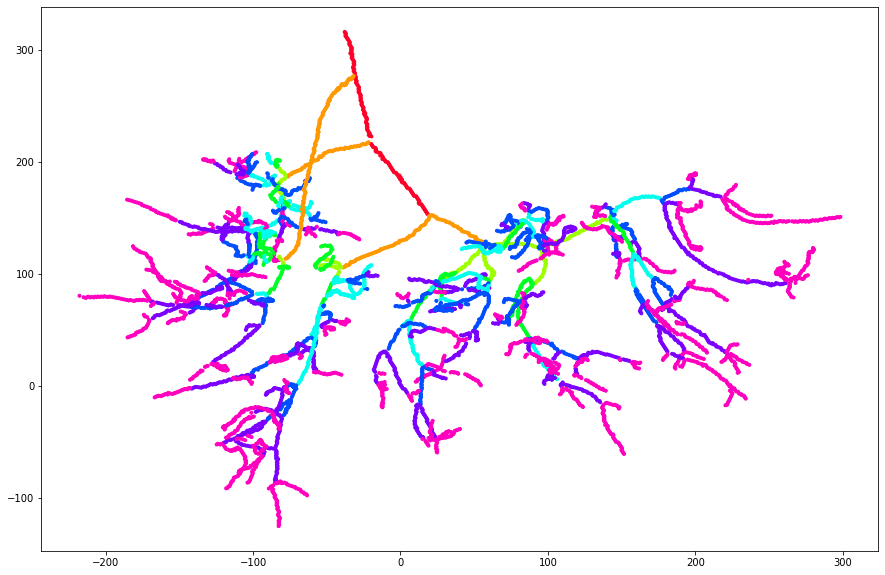

In [33]:
points = np.concatenate([e['voxels2d'] for e in dag.edges])
colors = np.concatenate([np.full(len(e['voxels2d']), fill_value=e['generation']) for e in dag.edges])
proper_indices = colors <= max_generations.get(TREE_NAME, 8)
points = points[proper_indices]
colors = colors[proper_indices]

plt.figure(figsize=(15, 10))
plt.scatter(points[:, 0], points[:, 1], c=colors, s=9, cmap='gist_rainbow')

## Volume filled with vascular structure

In [34]:
dag['vascular_structure_volume'] = np.sum(reconstruction > 0)
np.sum(reconstruction > 0)

2295797

## Mean interstitial distance to the nearest vessel

In [35]:
def add_parent_to_nodes(dag):
    dag.root['parent'] = None
    for e in dag.edges:
        e.node_b['parent'] = e.node_a
        
add_parent_to_nodes(dag)

In [36]:
def add_centroid_to_edges(dag):
    for e in dag.edges:
        e['centroid'] = np.mean(e['voxels'], axis=0)
        
add_centroid_to_edges(dag)

In [37]:
def get_edges_with_dfs(root):
    edges = []
    for e in root.edges:
        edges += [e]
        edges += get_edges_with_dfs(e.node_b)
    return edges

def get_closest_edge_distance(chosen_edge, cousin_edge):
    children_edges = get_edges_with_dfs(cousin_edge.node_b) + [cousin_edge]

    distances = [np.linalg.norm(chosen_edge['centroid'] - e['centroid']) for e in children_edges] 

    if len(distances) == 0:
        return np.inf
    return np.min(distances)
            

def get_interstitial_distance(chosen_edge):
    min_dist = np.inf
    
    parent = chosen_edge.node_a
    old_parent = chosen_edge.node_b
    while parent is not None:
        for edge in parent.edges:
            if edge.node_b == old_parent:
                continue
            min_dist = np.min([min_dist, get_closest_edge_distance(chosen_edge, edge)])
        old_parent = parent
        parent = parent['parent']
        
    return min_dist


def set_interstitial_distances(dag):
    for edge in dag.edges:
        edge['interstitial_distance'] = get_interstitial_distance(edge)

In [38]:
%%time
set_interstitial_distances(dag)

CPU times: user 7min 33s, sys: 2.53 s, total: 7min 35s
Wall time: 7min 33s


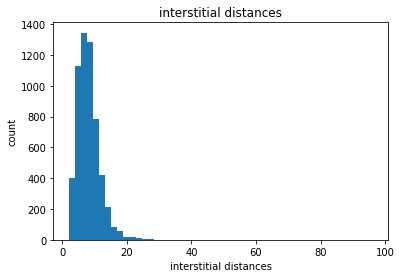

In [39]:
angles = [edge['interstitial_distance'] for edge in dag.edges[1:]]
plt.title('interstitial distances')
plt.hist(angles, bins=50)

plt.xlabel('interstitial distances')
plt.ylabel('count')
plt.show()

In [40]:
visualization = np.zeros(dag.volume_shape)
visualization = draw_edges(visualization, dag.edges, value='interstitial_distance')
visualize_gradient(visualization)

## Area covered by vascular network (overall size)

In [41]:
def project_reconstruction(reconstruction):
    reconstruction_coords = np.argwhere(reconstruction > 0)
    pca = PCA(n_components=2)
    pca.fit(reconstruction_coords)
    return pca.transform(reconstruction_coords)

reconstruction_projection = project_reconstruction(reconstruction)

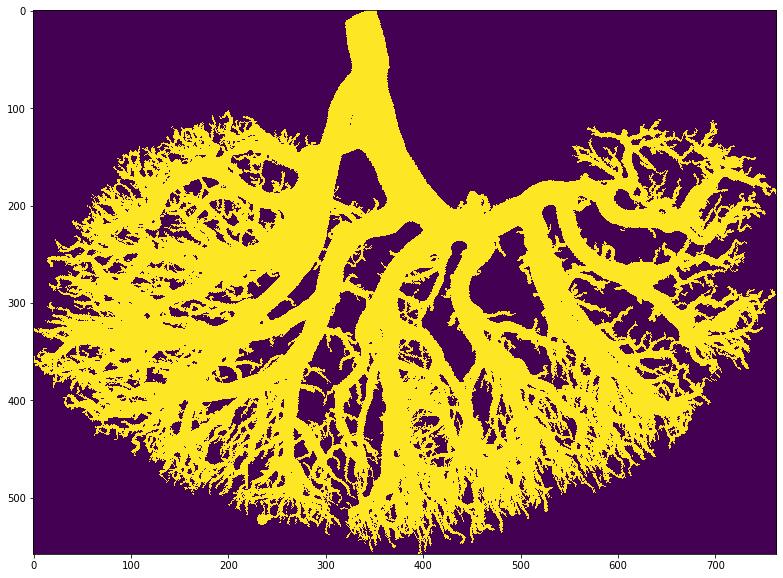

In [42]:
rounded_reconstruction_projection = np.round(reconstruction_projection)
mins = np.min(reconstruction_projection, axis=0)
shifted_projection = (rounded_reconstruction_projection - mins).astype(np.int)
reconstruction_projection_mask = np.zeros(np.max(shifted_projection + 1, axis=0), dtype=np.bool)
reconstruction_projection_mask[shifted_projection[:, 0], shifted_projection[:, 1]] = 1
plt.figure(figsize=(15, 10))
plt.imshow(reconstruction_projection_mask.T)
plt.show()

In [43]:
dag['vascular_network_projection_area'] = np.sum(reconstruction_projection_mask)
np.sum(reconstruction_projection_mask)

173506

## Vascular density

In [44]:
convex_projection = convex_hull_image(reconstruction_projection_mask)

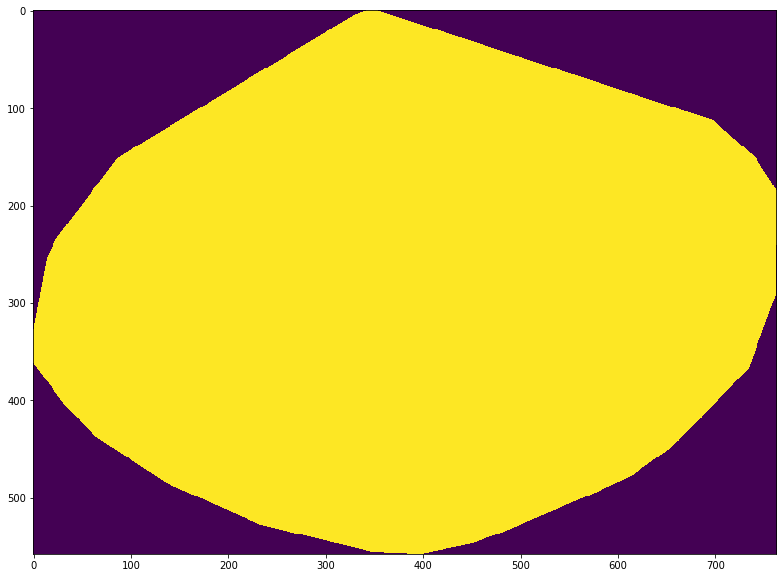

In [45]:
plt.figure(figsize=(15, 10))
plt.imshow(convex_projection.T)
plt.show()

In [46]:
dag['projection_explant_area'] = convex_projection.sum()
dag['vascular_density'] = dag['vascular_network_projection_area'] / dag['projection_explant_area']
print(dag['vascular_network_projection_area'])
print(dag['projection_explant_area'])
print(dag['vascular_density'])

173506
305287
0.5683373350322811


## Branching index - measurement of sprouting activity

In [47]:
def get_number_of_branching_points(dag):
    nodes_with_children = [n for n in dag.nodes if len(n.edges) != 0]
    branch_nodes = [n for n in nodes_with_children if n['parent'] is not None]
    return len(branch_nodes)

number_of_branching_points = get_number_of_branching_points(dag)
dag['branching_points'] = number_of_branching_points
number_of_branching_points

2701

In [48]:
dag['branchings_points_per_pixel'] = dag['branching_points'] / dag['vascular_network_projection_area']
dag['branchings_points_per_pixel']

0.015567184996484271

## Lacunarity 

In [49]:
def calculate_one_box_lacunarity(projection, box_size):
    box = np.ones((box_size, box_size))
    convolution = signal.convolve2d(projection, box, mode='valid')
    mean_sqrd = np.mean(convolution)**2
    if mean_sqrd == 0:
        return 0.0
    return (np.var(convolution) / mean_sqrd) + 1

def calculate_avg_lacunarity(projection, box_sizes):
    lacunarities = [calculate_one_box_lacunarity(projection, box_size) for box_size in box_sizes]
    return np.mean(lacunarities)

In [50]:
%%time
box_sizes = [10, 30, 50, 70, 90, 110, 130, 150]
dag['lacunarity'] = calculate_avg_lacunarity(reconstruction_projection_mask, box_sizes)
dag['lacunarity']

CPU times: user 1min 22s, sys: 79.9 ms, total: 1min 22s
Wall time: 1min 22s


1.4061372300706634

## Fractal dimension

In [51]:
def get_projection_contour(projection):
    padded_projection = np.pad(projection, 1)
    contour = np.zeros(padded_projection.shape)
    projection_pixels = np.argwhere(padded_projection)
    kernel = np.ones((3, 3))
    kernel[1, 1] = 0
    for pixel in projection_pixels:
        x, y = tuple(pixel)
        projection_slice = padded_projection[x-1 : x+2, y-1 : y+2]
        if np.sum(projection_slice * kernel) < 8:
            contour[x, y] = 1
    return contour[1:-1, 1:-1]

[46010, 39643, 33638, 27946, 22587, 17452, 12442, 8077, 4266]

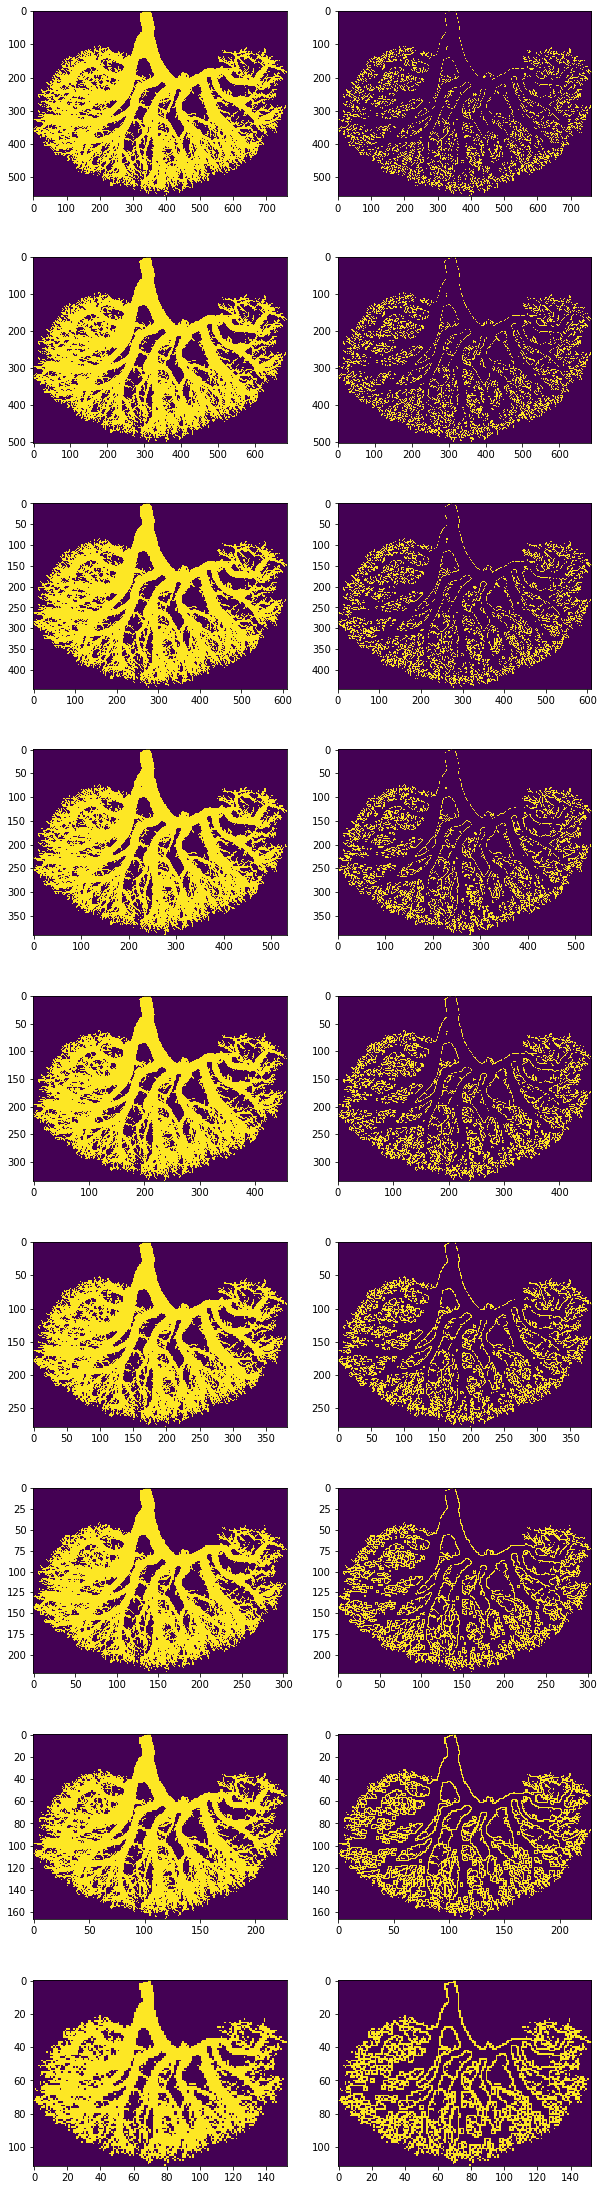

In [52]:
contours_lengths =[]
scales = np.arange(1, 0.1, -0.1)

plt.figure(figsize=(10, 40))
for i, scale in enumerate(scales):
    proj = zoom(reconstruction_projection_mask, scale, order=0)
    contour = get_projection_contour(proj)
    plt.subplot(len(scales), 2, 2 * i + 1)
    plt.imshow(proj.T)
    plt.subplot(len(scales), 2, 2 * i + 2)
    plt.imshow(contour.T)
    contours_lengths.append(int(np.sum(contour)))

contours_lengths

In [53]:
X = np.expand_dims(np.log(scales), axis=-1)
y = np.expand_dims(np.log(contours_lengths), axis=-1)
lm = LinearRegression().fit(X, y)
lm.coef_[0, 0]

1.4701200397715684

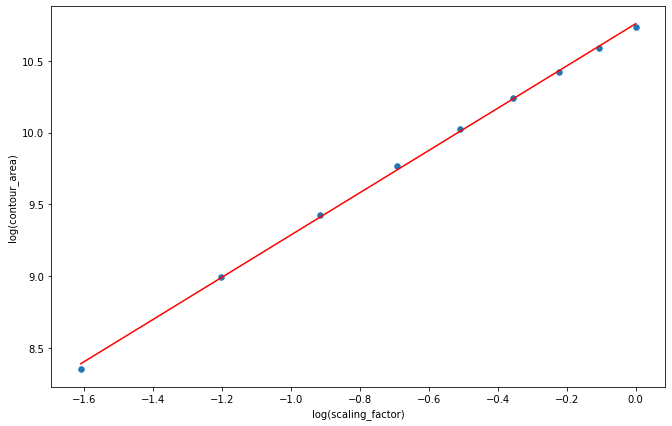

In [54]:
plt.figure(figsize=(11, 7))
plt.scatter(np.log(scales), np.log(contours_lengths), s=30)
plt.plot(np.log(scales), lm.predict(np.log(scales).reshape(-1, 1)), color='red')
plt.xlabel('log(scaling_factor)')
plt.ylabel('log(contour_area)')
plt.show()

In [55]:
dag['fractal_dimension'] = lm.coef_[0, 0]

## Saving DAG with stats

In [56]:
save_dag(dag, source_dir + TREE_NAME + '/dag-with-stats.pkl')